In [4]:
from google.colab import drive

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
import datetime
import os
from PIL import Image

In [6]:
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
data_folder_1200 = '/content/drive/MyDrive/catsanddogs/data_1200'

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#x = None
# Function to load images from a directory
def load_images(directory):
    images = []
    labels = []
    vectors = []
    label_encoder = LabelEncoder()
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust as per your image formats
                img = Image.open(os.path.join(label_dir, filename))
                img = img.resize((150, 150))  # Resize the image to your desired size
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                vector = img.flatten()
                #print(vector)
                #print(len(vector))
                #print(os.path.join(label_dir, filename))
                if len(vector) == 67500:
                  #np.array(vectors)
                  vectors.append(vector)
                  images.append(img)
                  labels.append(label)  # Assuming folder names are the labels
                #x = vector
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return np.array(images), np.array(vectors), labels


In [66]:
train_dir_1200 = os.path.join(data_folder_1200, 'training')
test_dir_1200 = os.path.join(data_folder_1200, 'testing')
add_test_dir_1200 = os.path.join(data_folder_1200, 'additional_testing')

In [11]:
# Load train and test images
train_images_1200, train_vectors_1200, train_labels_1200 = load_images(train_dir_1200)
test_images_1200, test_vectors_1200, test_labels_1200 = load_images(test_dir_1200)


In [67]:
add_test_images_1200, add_test_vectors_1200, add_test_labels_1200 = load_images(add_test_dir_1200)

In [44]:
# import glob
# len([x for x in glob.glob(f"{train_dir_1200}/dogs/*") if x.endswith(".jpg")])

500

In [13]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss, optimizer):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów (kerneli) w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())



    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model

In [14]:

opt_Adam = tf.keras.optimizers.Adam()
opt_SGD = tf.keras.optimizers.SGD()

In [15]:
train_images_1200.shape

(997, 150, 150, 3)

In [16]:
CNN_1200_SGD = create_cnn_model(
    inShape= train_images_1200.shape[1:],
    convNum= [4,4,4,4],
    hNum = [400],
    hAct = 'relu',
    outNum = 2,
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = opt_SGD

)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 4)         0

In [17]:
historyCNN1200SGD = CNN_1200_SGD.fit(
    x = train_images_1200,
    y = train_labels_1200,
    epochs = 10,
    validation_split = 0.05,
    shuffle = True,
    batch_size = 60,
)

Epoch 1/10
12/16 [=====================>........] - ETA: 2s - loss: 0.6933 - accuracy: 0.4972

KeyboardInterrupt: 

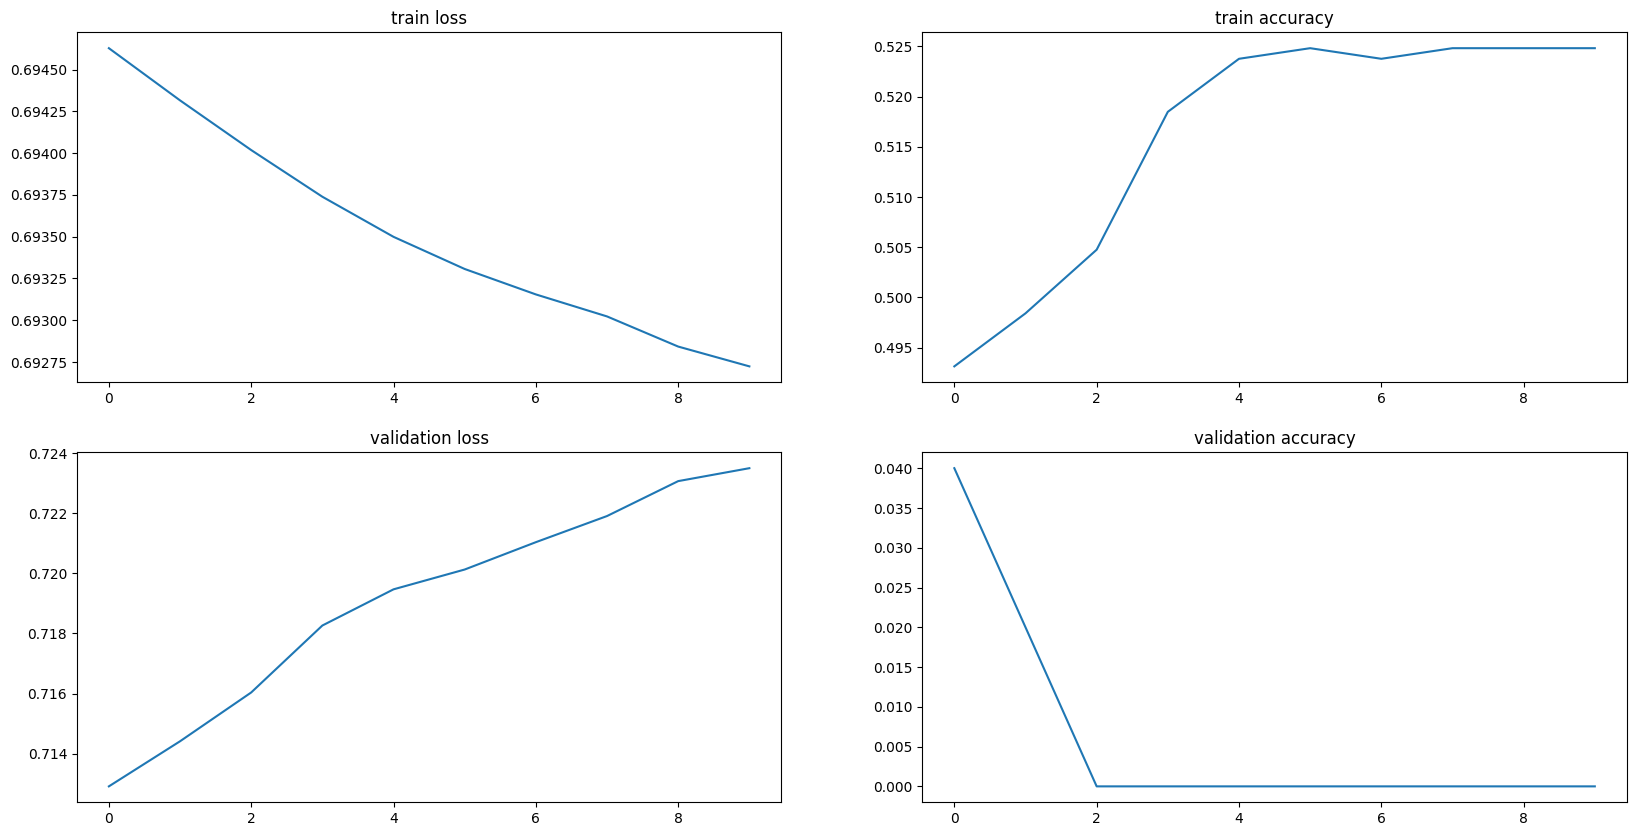

In [19]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200SGD.history["loss"])
ax[0][1].plot(historyCNN1200SGD.history["accuracy"])
ax[1][0].plot(historyCNN1200SGD.history["val_loss"])
ax[1][1].plot(historyCNN1200SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [23]:
y_predCNN_SGD_1200 = CNN_1200_SGD.predict(test_images_1200)

print(classification_report(y_predCNN_SGD_1200.argmax(axis=1), test_labels_1200.argmax(axis=1)))

7/7 [==============================] - 1s 114ms/step
              precision    recall  f1-score   support

           0       0.47      0.56      0.51        84
           1       0.63      0.54      0.58       116

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.56      0.55      0.55       200



In [22]:
CNN_1200_Adam = create_cnn_model(
    inShape= train_images_1200.shape[1:],
    convNum= [4,4,4,4],
    hNum = [400],
    hAct = 'relu',
    outNum = 2,
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = opt_Adam

)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 4)        

In [21]:
historyCNN1200Adam = CNN_1200_Adam.fit(
    x = train_images_1200,
    y = train_labels_1200,
    epochs = 10,
    validation_split = 0.05,
    shuffle = True,
    batch_size = 60,
)

NameError: name 'CNN_1200_Adam' is not defined

In [25]:
y_predCNN_Adam_1200 = CNN_1200_Adam.predict(test_images_1200)

print(classification_report(y_predCNN_Adam_1200.argmax(axis=1), test_labels_1200.argmax(axis=1)))

7/7 [==============================] - 2s 212ms/step
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       107
           1       0.60      0.65      0.62        93

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.64      0.64      0.64       200



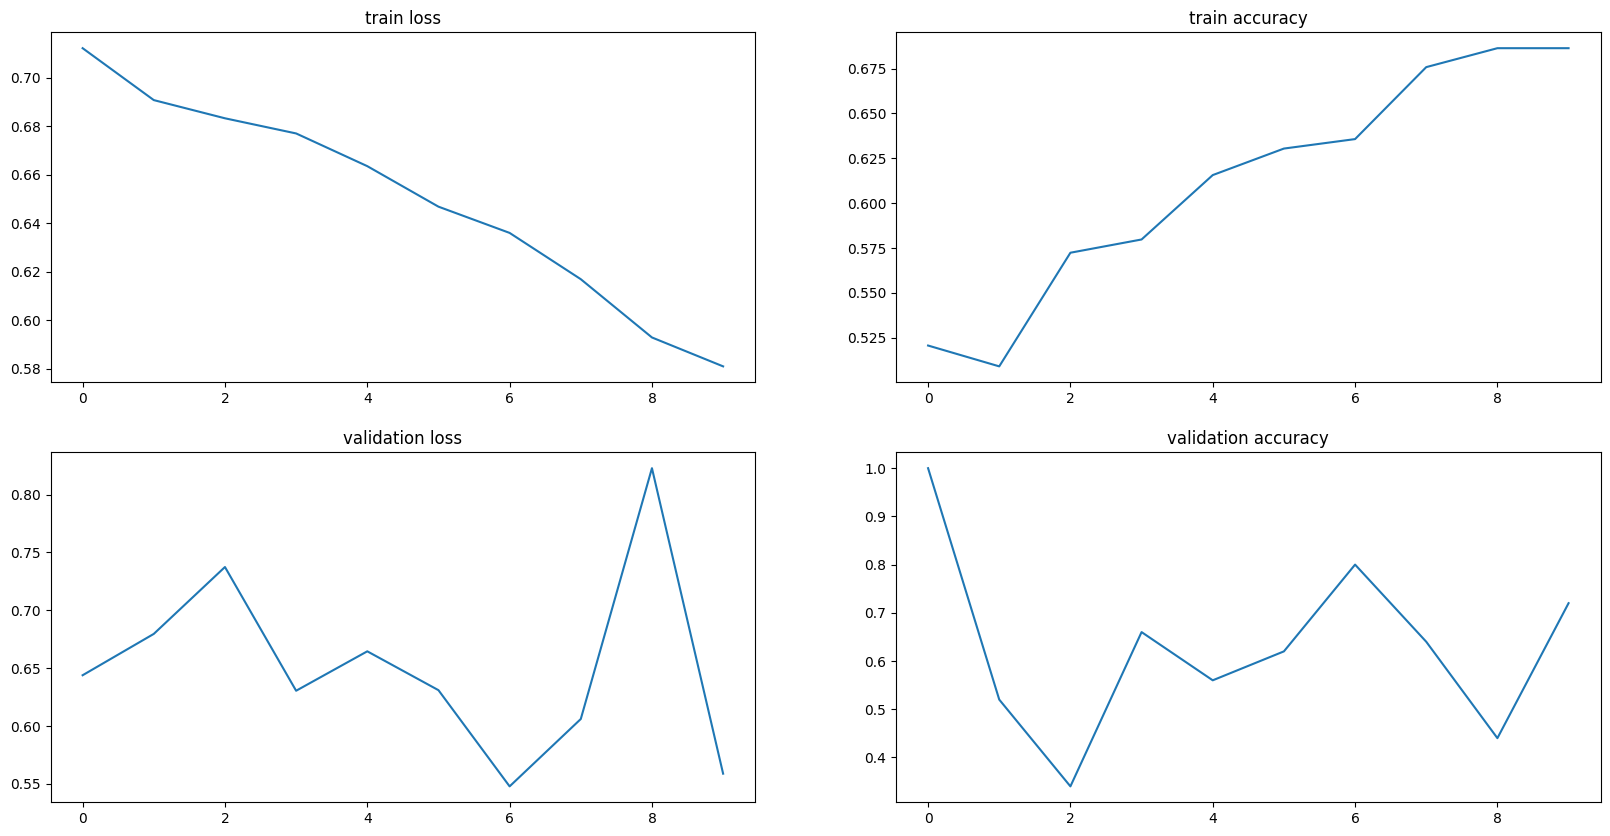

In [26]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200Adam.history["loss"])
ax[0][1].plot(historyCNN1200Adam.history["accuracy"])
ax[1][0].plot(historyCNN1200Adam.history["val_loss"])
ax[1][1].plot(historyCNN1200Adam.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [20]:
historyCNN1200Adam_100epochs = CNN_1200_Adam.fit(
    x = train_images_1200,
    y = train_labels_1200,
    epochs = 100,
    validation_split = 0.05,
    shuffle = True,
    batch_size = 60,
)

NameError: name 'CNN_1200_Adam' is not defined

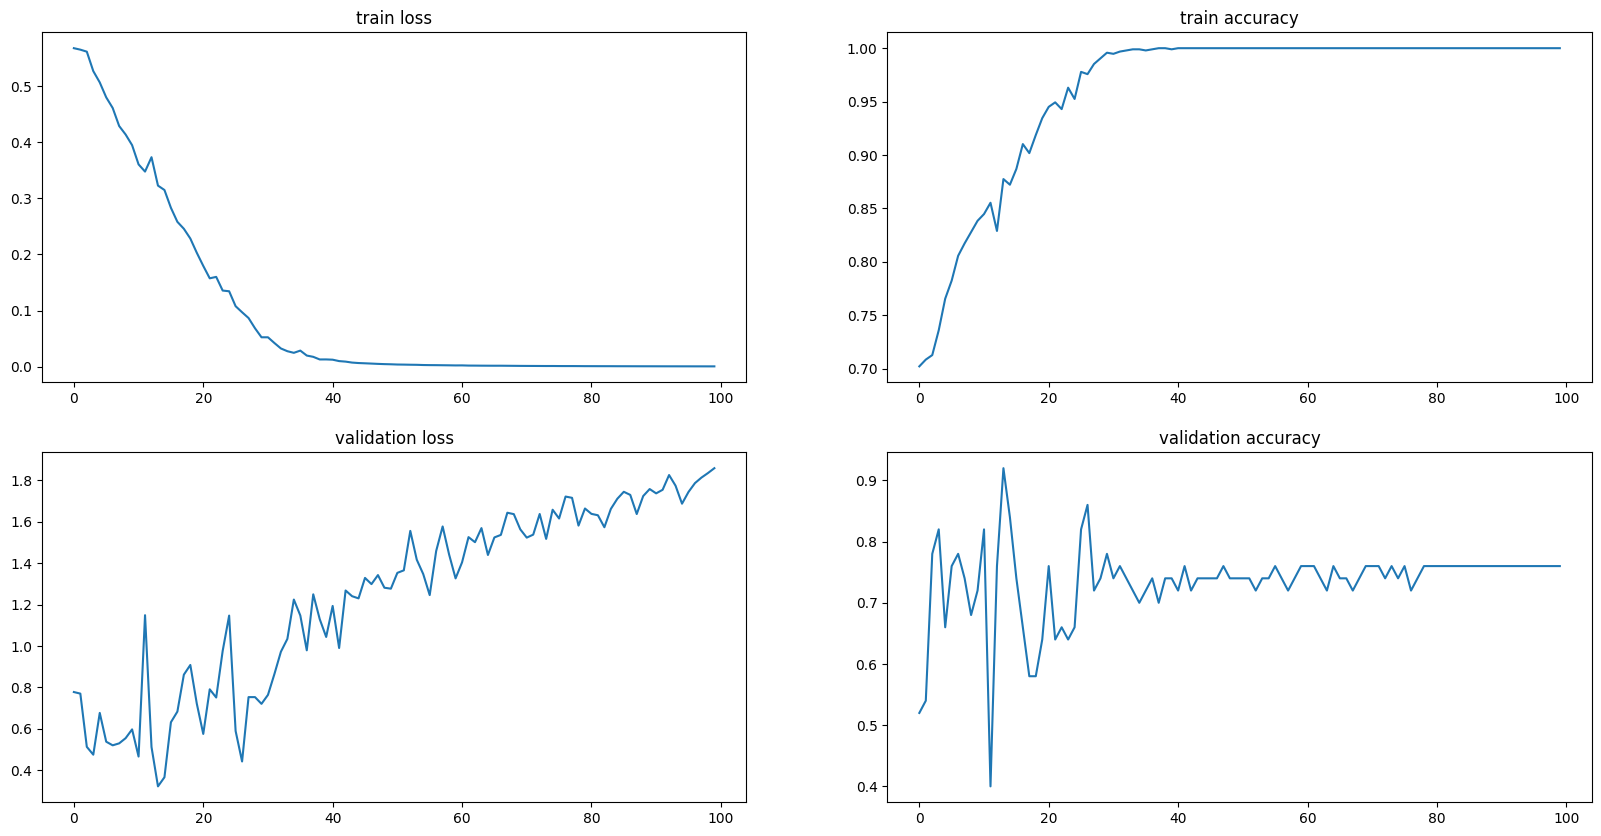

In [28]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200Adam_100epochs.history["loss"])
ax[0][1].plot(historyCNN1200Adam_100epochs.history["accuracy"])
ax[1][0].plot(historyCNN1200Adam_100epochs.history["val_loss"])
ax[1][1].plot(historyCNN1200Adam_100epochs.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [29]:
y_predCNN_Adam_1200_100epochs = CNN_1200_Adam.predict(test_images_1200)

print(classification_report(y_predCNN_Adam_1200_100epochs.argmax(axis=1), test_labels_1200.argmax(axis=1)))

7/7 [==============================] - 2s 278ms/step
              precision    recall  f1-score   support

           0       0.66      0.59      0.63       111
           1       0.55      0.62      0.58        89

    accuracy                           0.60       200
   macro avg       0.60      0.61      0.60       200
weighted avg       0.61      0.60      0.61       200



In [41]:
resized_test1200images.shape

TensorShape([200, 224, 224, 3])

In [42]:
test_images_1200.shape[1:]

(150, 150, 3)


The subsequent phase entails transfer learning, wherein the classification of cats and dogs relies on a pre-trained network. This pre-trained model, trained on an extensive dataset, serves as a versatile model suitable for various classification tasks, such as the categorization of cats and dogs in this scenario. Several base models have been designated, including MobileNetV2, MobileNetV3Large and VGG16.

In [96]:
#transfer learning

resized_train1200images = tf.image.resize(train_images_1200, (224, 224))
resized_test1200images = tf.image.resize(test_images_1200, (224, 224))
resized_addtest1200images = tf.image.resize(add_test_images_1200, (224,224))

inputLayer = tf.keras.Input(shape =resized_test1200images.shape[1:] )


# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
base_model = tf.keras.applications.MobileNetV3Large(
#base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape= resized_test1200images.shape[1:],
    include_top=False)


12683000/12683000 [==============================] - 0s 0us/step


In [97]:
base_model.trainable = False

In [98]:
# adding last layers
x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [99]:
# model with MobileNetV2 as a base_model
model = tf.keras.Model(inputLayer, output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2997313 (11.43 MB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [100]:
# optimizer = tf.keras.optimizers.legacy.Adam
opt_Adam.build(model.trainable_variables)

In [101]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    run_eagerly=True
)

In [79]:
binary_train_labels_1200 = np.argmax(train_labels_1200, axis = 1)
binary_test_labels_1200 = np.argmax(test_labels_1200, axis = 1)
binary_add_test_labels_1200 = np.argmax(add_test_labels_1200, axis=1)

In [ ]:
historyTF = model.fit(
    resized_train1200images,
    binary_train_labels_1200,
    epochs=10,
    validation_data= (resized_test1200images, binary_test_labels_1200)
)

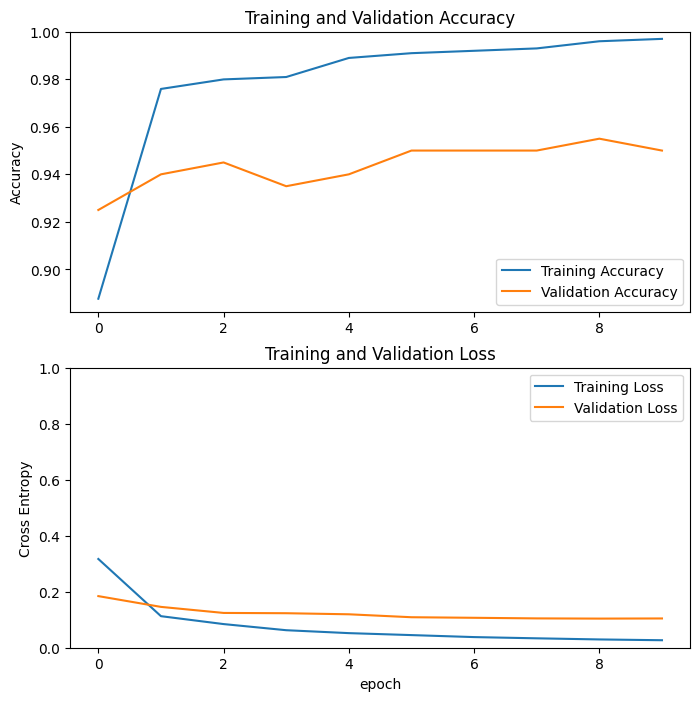

In [63]:
acc = historyTF.history['accuracy']
val_acc = historyTF.history['val_accuracy']

loss = historyTF.history['loss']
val_loss = historyTF.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [74]:
yTF_pred = model.predict(resized_addtest1200images)

5/5 [==============================] - 13s 3s/step


In [84]:
print(classification_report(yTF_pred.argmax(axis=1), add_test_labels_1200.argmax(axis=1)))



# dlaczego wszystkie przypadki są zaklasyfikowane jako 0?

              precision    recall  f1-score   support

           0       1.00      0.50      0.67       150
           1       0.00      0.00      0.00         0

    accuracy                           0.50       150
   macro avg       0.50      0.25      0.33       150
weighted avg       1.00      0.50      0.67       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# accuracy for the base model V2 mobilenet is 0.9667
loss, accuracy = model.evaluate(resized_addtest1200images, add_test_labels_1200.argmax(axis=1))


5/5 [==============================] - 14s 2s/step - loss: 0.0912 - accuracy: 0.9667


In [94]:
yTF_pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [71]:
print('Test accuracy :', accuracy)

Test accuracy : 0.0


In [ ]:
resized_test1200images

In [ ]:
resized_addtest1200images

In [81]:
binary_add_test_labels_1200.shape

(150,)

In [ ]:
add_test_images_1200

In [102]:
#model with V3Large as a base model


historyTF_V3 = model.fit(
    resized_train1200images,
    binary_train_labels_1200,
    epochs=10,
    validation_data= (resized_test1200images, binary_test_labels_1200)
)

Epoch 1/10
32/32 [==============================] - 156s 5s/step - loss: 0.6985 - accuracy: 0.4544 - val_loss: 0.6936 - val_accuracy: 0.4950
Epoch 2/10
32/32 [==============================] - 142s 4s/step - loss: 0.6951 - accuracy: 0.4674 - val_loss: 0.6936 - val_accuracy: 0.4950
Epoch 3/10
32/32 [==============================] - 151s 5s/step - loss: 0.6929 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 151s 5s/step - loss: 0.6935 - accuracy: 0.5005 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/10
32/32 [==============================] - 154s 5s/step - loss: 0.6936 - accuracy: 0.5125 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 149s 5s/step - loss: 0.6919 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 7/10
32/32 [==============================] - 144s 5s/step - loss: 0.6905 - accuracy: 0.5456 - val_loss: 0.6917 - val_accuracy: 0.5050
Epoch 8/10
32

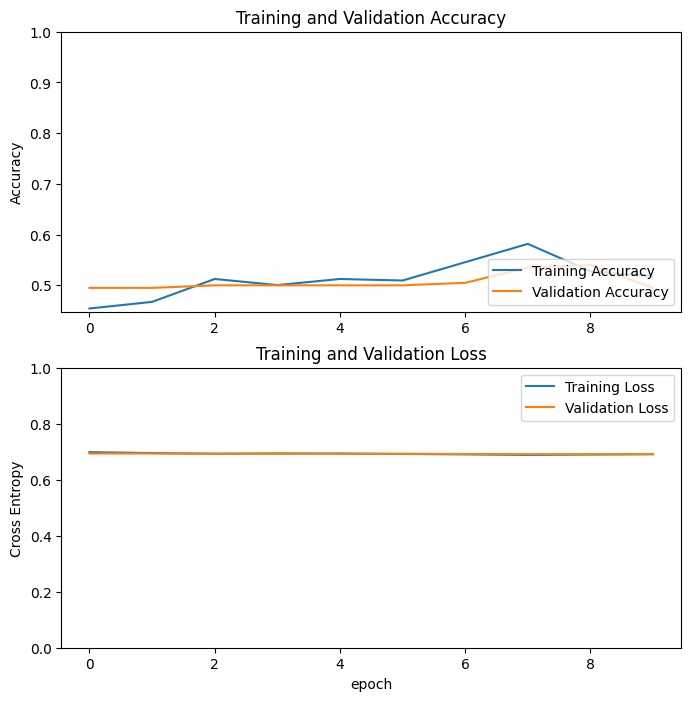

In [103]:
acc = historyTF_V3.history['accuracy']
val_acc = historyTF_V3.history['val_accuracy']

loss = historyTF_V3.history['loss']
val_loss = historyTF_V3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [104]:
loss, accuracy = model.evaluate(resized_addtest1200images, add_test_labels_1200.argmax(axis=1))

5/5 [==============================] - 6s 1s/step - loss: 0.6848 - accuracy: 0.5000


In [105]:
yTF_V3_pred = model.predict(resized_addtest1200images)

5/5 [==============================] - 12s 2s/step


In [119]:
print(classification_report(yTF_V3_pred.argmax(axis=1), add_test_labels_1200.argmax(axis=1)))



              precision    recall  f1-score   support

           0       1.00      0.50      0.67       150
           1       0.00      0.00      0.00         0

    accuracy                           0.50       150
   macro avg       0.50      0.25      0.33       150
weighted avg       1.00      0.50      0.67       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
# checking the default value of learning rate
adam_optimizer = tf.keras.optimizers.Adam()

# Access the learning rate attribute of the optimizer
default_learning_rate = adam_optimizer.learning_rate.numpy()

print("Default learning rate:", default_learning_rate)


Default learning rate: 0.001


In [ ]:
# As the results are unsatisfactory, will try to increase learning rate

learning_rate = 0.01

In [122]:
# data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

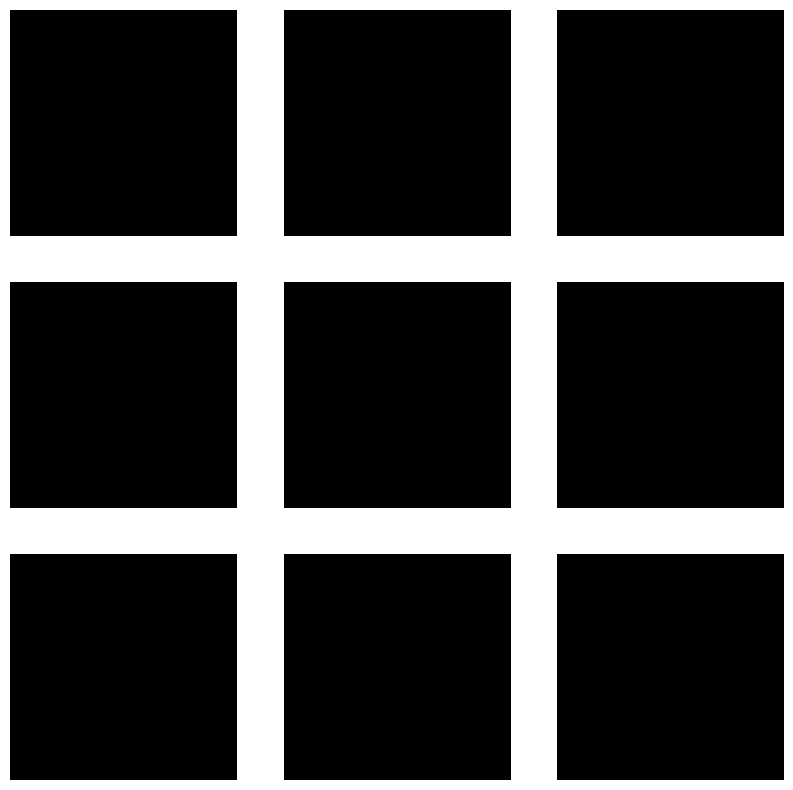

In [126]:
# for image, _ in train_images_1200.take(1):
plt.figure(figsize=(10, 10))
image = cv2.imread()
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

In [128]:
train_dir_1200[0]

'/'

In [ ]:
# fitting a model with a base model V3Large with dropout amounting to 0.5

In [88]:
# Retrieve a batch of images from the test set
image_batch, label_batch = add_test_images_1200.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

AttributeError: 'numpy.ndarray' object has no attribute 'as_numpy_iterator'

In [30]:
train_labels_1200.shape

(997, 2)

In [1]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_ali

(200, 67500)

The analysis provided below represents the initial examination, conducted on a training set comprising 100 images, with a testing set of 30 images. However, the outcomes derived from this smaller dataset were found to be unsatisfactory. Therefore, the analysis presented above was undertaken to reassess the findings.

In [10]:
data_folder = '/content/drive/MyDrive/catsanddogs/data'

In [11]:
train_dir = os.path.join(data_folder, 'training')
test_dir = os.path.join(data_folder, 'testing')

In [12]:
# Load train and test images
train_images, train_vectors, train_labels = load_images(train_dir)
test_images, test_vectors, test_labels = load_images(test_dir)

In [13]:
batch_size = 20
img_size = (150, 150)

In [ ]:
# #loading dataset from the directory

# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     train_dir,
#     shuffle=True,
#     batch_size = batch_size,
#     image_size = img_size
# )

In [ ]:
# #loading testing dataset

# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     shuffle=True,
#     batch_size = batch_size,
#     image_size = img_size
)

In [14]:
train_vectors.shape

(150, 67500)

In [15]:
train_images.shape

(150, 150, 150, 3)

In [16]:
train_labels.shape

(150, 2)

In [ ]:
# class_names = test_dataset.class_names

In [35]:
# class_names


In [16]:
classNum = train_labels.shape[1]

In [17]:
# creating a simple ANN - artificial neural network

def create_model(hNum, act, optimizer):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(train_vectors.shape[1])))
    model.add(layers.Dense(hNum, activation=act, name="hidden"))
    model.add(layers.Dense(classNum, name="output"))
    model.add(layers.Softmax())
    print(model.summary())



    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

    return model

In [ ]:
#creating model with SGD optimizer
optSGD = tf.keras.optimizers.SGD()

modelANN_SGD = create_model(10, 'relu', optSGD)


In [ ]:
historyANN_SGD = modelANN_SGD.fit(train_vectors, train_labels, batch_size=20, epochs =10, verbose=2, validation_split=0.05)

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyANN_SGD.history["loss"])
ax[0][1].plot(historyANN_SGD.history["accuracy"])
ax[1][0].plot(historyANN_SGD.history["val_loss"])
ax[1][1].plot(historyANN_SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
y_predANN_SGD.argmax(axis=1)

In [ ]:
y_predANN_SGD.shape

In [ ]:
test_labels.argmax(axis=1)

In [ ]:
y_predANN_SGD = modelANN_SGD.predict(test_vectors)

print(classification_report(y_predANN_SGD.argmax(axis=1), test_labels.argmax(axis=1)))

In [ ]:
#creating model with Adam optimizer

optAdam = tf.keras.optimizers.Adam()

modelANN_Adam = create_model(10, 'relu', optAdam)

In [ ]:
historyANN_Adam = modelANN_Adam.fit(train_vectors, train_labels, batch_size=20, validation_split=0.05, verbose =2, epochs = 100)

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyANN_Adam.history["loss"])
ax[0][1].plot(historyANN_Adam.history["accuracy"])
ax[1][0].plot(historyANN_Adam.history["val_loss"])
ax[1][1].plot(historyANN_Adam.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
y_predANN_Adam = modelANN_Adam.predict(test_vectors)

print(classification_report(y_predANN_Adam.argmax(axis=1), test_labels.argmax(axis=1)))

In [ ]:
# train_dataset.element_spec[0].shape.as_list()[1:]

In [ ]:
modelCNN_Adam = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    outNum=2,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam()
)

In [ ]:
historyCNN_Adam = modelCNN_Adam.fit(
    x= train_images,
    y=train_labels,
    batch_size=60,
    epochs=10,
    validation_split=0.05,
    verbose=0
)

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(historyCNN_Adam.history["loss"])
ax[0][1].plot(historyCNN_Adam.history["accuracy"])
ax[1][0].plot(historyCNN_Adam.history["val_loss"])
ax[1][1].plot(historyCNN_Adam.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()


In [ ]:
# testing
y_pred_CNN_Adam = modelCNN_Adam.predict(test_images)
print(classification_report(test_labels.argmax(axis=1), y_pred_CNN_Adam.argmax(axis=1)))

In [ ]:
modelCNN_SGD = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    outNum=2,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD()
)

In [ ]:
historyCNN_SGD = modelCNN_SGD.fit(
    x= train_images,
    y=train_labels,
    batch_size=20,
    epochs=10,
    validation_split=0.05)

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD.history["loss"])
ax[0][1].plot(historyCNN_SGD.history["accuracy"])
ax[1][0].plot(historyCNN_SGD.history["val_loss"])
ax[1][1].plot(historyCNN_SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
# testing
y_pred_CNN_SGD = modelCNN_SGD.predict(test_images)
print(classification_report(test_labels.argmax(axis=1), y_pred_CNN_SGD.argmax(axis=1)))

In [ ]:
#checking whether increasing the number of epochs will improve the results

historyCNN_SGD_1000epochs = modelCNN_SGD.fit(
    x= train_images,
    y=train_labels,
    batch_size=20,
    epochs=1000,
    validation_split=0.05)

In [ ]:
# testing

trained_1000epochs_model = historyCNN_SGD_1000epochs.model
y_pred_1000epochs = trained_1000epochs_model.predict(test_images)

print(classification_report(test_labels.argmax(axis=1), y_pred_1000epochs.argmax(axis=1)))

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD_1000epochs.history["loss"])
ax[0][1].plot(historyCNN_SGD_1000epochs.history["accuracy"])
ax[1][0].plot(historyCNN_SGD_1000epochs.history["val_loss"])
ax[1][1].plot(historyCNN_SGD_1000epochs.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [19]:
def create_cnn_model_with_dropout(inShape, convNum, hNum, hAct, outNum, loss, optimizer, dropout_rate):

    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))

    for idx, oneConvNum in enumerate(convNum):

        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )

        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )

    model.add(layers.Flatten())

    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
        model.add(Dropout(rate=dropout_rate))

    model.add(layers.Dense(outNum))

    model.add(layers.Softmax())
    print(model.summary())



    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model

In [ ]:
#adding dropout to prevent overfitting

modelCNN_SGD_dropout = create_cnn_model_with_dropout(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    outNum=2,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD(),
    dropout_rate=0.1
)



historyCNN_SGD_dropout_0_1 = modelCNN_SGD_dropout.fit(
    x= train_images,
    y=train_labels,
    batch_size=20,
    epochs=10,
    validation_split=0.05,
    verbose=0
      )


In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD_dropout_0_1.history["loss"])
ax[0][1].plot(historyCNN_SGD_dropout_0_1.history["accuracy"])
ax[1][0].plot(historyCNN_SGD_dropout_0_1.history["val_loss"])
ax[1][1].plot(historyCNN_SGD_dropout_0_1.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
# testing

y_pred_dropout_0_1 = modelCNN_SGD_dropout.predict(test_images)

print(classification_report(test_labels.argmax(axis=1), y_pred_dropout_0_1.argmax(axis=1)))

In [21]:
# creating a model with more hidden layers. Until now the models consisted of one dense layer.

modelCNN_Adam_sigmoid = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="sigmoid",
    outNum=2,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam()
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 4)        

In [23]:
historyCNN_Adam_sgimoid =modelCNN_Adam_sigmoid.fit(
    x= train_images,
    y=train_labels,
    batch_size=20,
    epochs=10,
    validation_split=0.05,
    verbose=0
      )

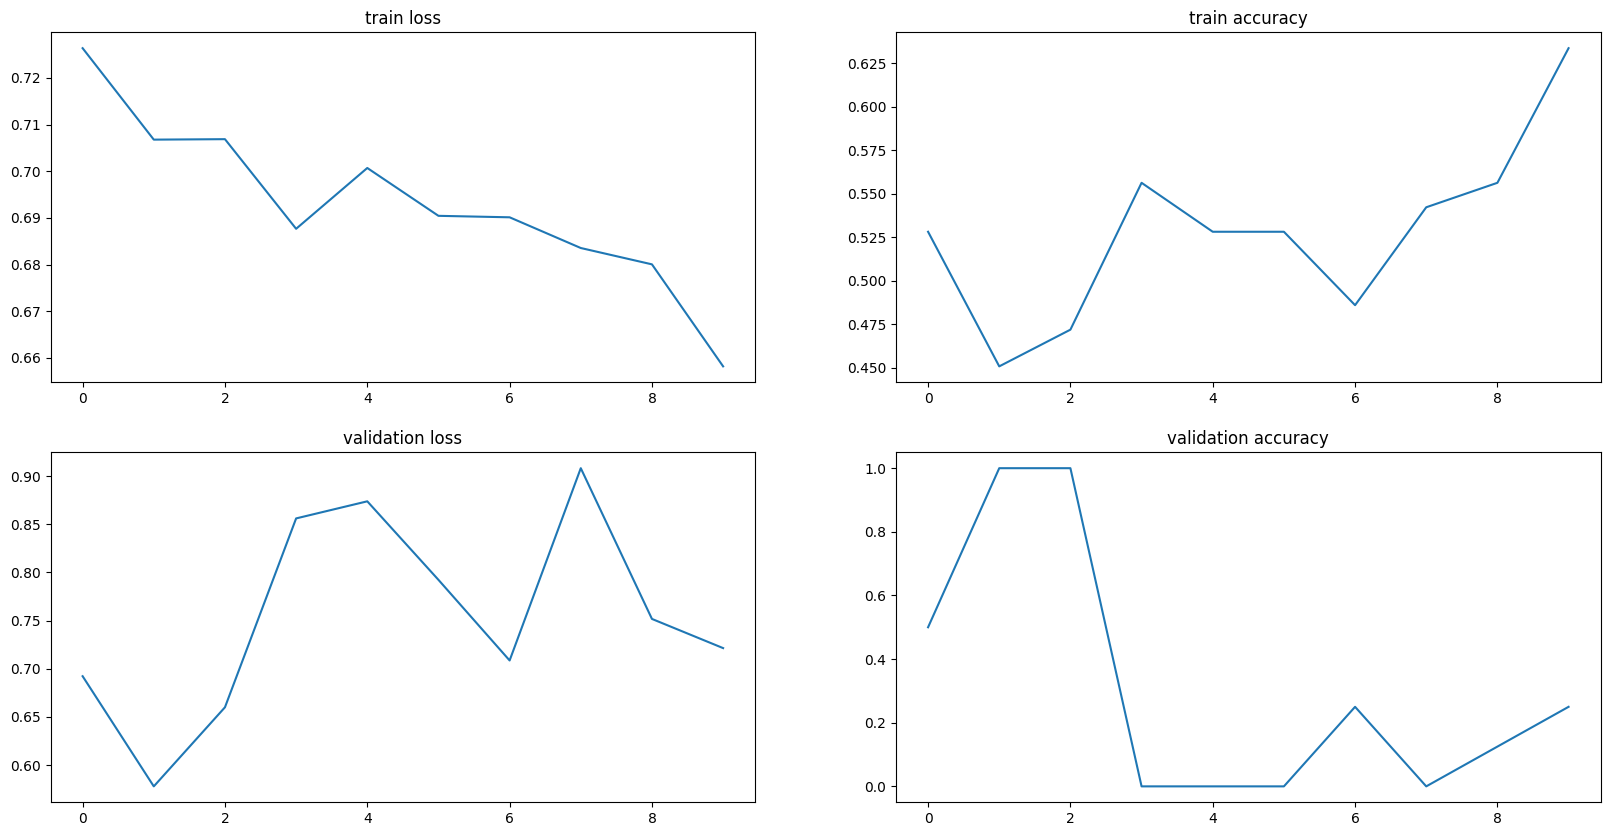

In [24]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_Adam_sgimoid.history["loss"])
ax[0][1].plot(historyCNN_Adam_sgimoid.history["accuracy"])
ax[1][0].plot(historyCNN_Adam_sgimoid.history["val_loss"])
ax[1][1].plot(historyCNN_Adam_sgimoid.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [25]:

modelCNN_SGD_sigmoid = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="sigmoid",
    outNum=2,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD()
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 19, 19, 4)        

In [26]:
historyCNN_SGD_sgimoid =modelCNN_SGD_sigmoid.fit(
    x= train_images,
    y=train_labels,
    batch_size=20,
    epochs=10,
    validation_split=0.05,
    verbose=0
      )

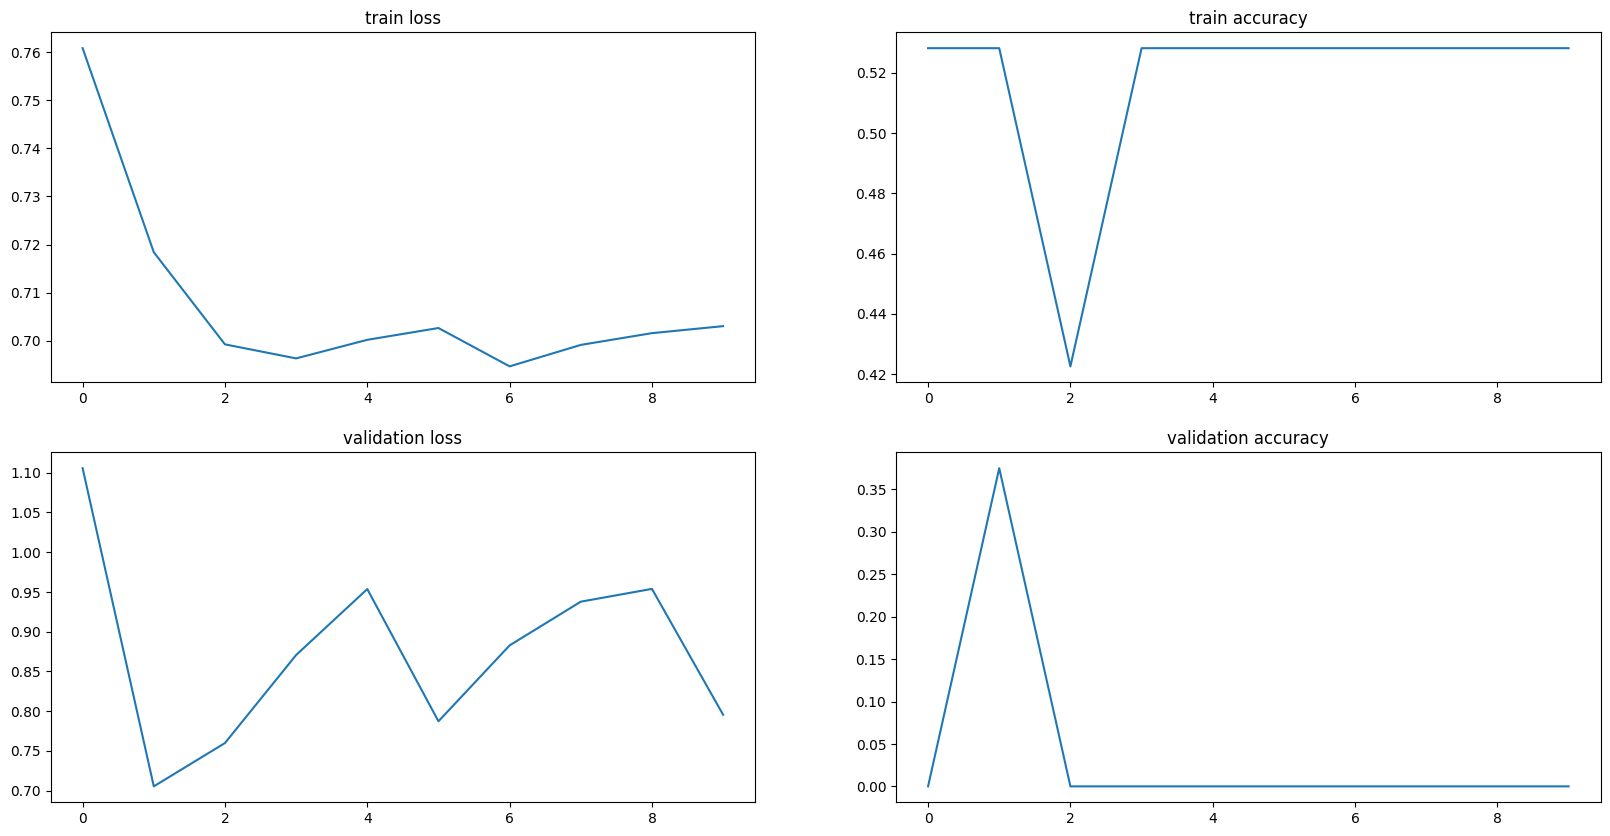

In [27]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD_sgimoid.history["loss"])
ax[0][1].plot(historyCNN_SGD_sgimoid.history["accuracy"])
ax[1][0].plot(historyCNN_SGD_sgimoid.history["val_loss"])
ax[1][1].plot(historyCNN_SGD_sgimoid.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()